## Neural Network (NN) Implementation for Adaptive Beamforming (ABF)

In this notebook, we define and train the NNs we employ for the task of null-steering beamforming. We import the dataset created in the previous lesson and we normalize inputs and outputs before using it for training. Finally, we illustrate the accuracy of the three beamformers (the NSB algorithm and the two NN models) on random DoA scenarios.

**IMPORTANT:**
* Change Runtime Type to a GPU!!
*   Make sure you have the *total_dataset.csv* file uploaded which is necessary for training the NNs. You can simply drag and drop the *total_dataset.csv* file to the "Files" section found on the left side of the notebook.
*   After training, both models are automatically downloaded. You can opt not to download the files by commenting the relevant lines in the training-related code snippets. The pre-trained models *ffnn_model.pt* and *lstm_model.pt*, will also be accessible in the "Files" section of this notebook after training is complete.



## Feedforward Neural Network (FFNN)

After performing grid search, the design of this model is as follows:

**LAYER TYPE:** **SIZE + (Activation Function)**

*Input Layer:*  3

*1st Hidden Layer:* 256 + (tanh)

*2nd Hidden Layer:* 512 + (tanh)

*Output Layer:*  32 + (sigmoid)



In [ ]:
import torch
import torch.nn as nn

# Device config
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

class FeedForwardNet(nn.Module):
    def __init__(self, layers):
        super(FeedForwardNet, self).__init__()
        # Initialize the model
        self.hidden = nn.ModuleList() # Hidden layer list

        # Fill the list depending on the layer size dictated by "layers"
        for input_size, output_size in zip(layers,layers[1:]):
          linear = nn.Linear(input_size, output_size)
          self.hidden.append(linear)

    def forward(self,activation):

        # Get the number of hidden layers
        L=len(self.hidden)

        # Use the tanh activation function after each hidden layer
        # Except the final layer, where we use the sigmoid
        for (l,linear_transform) in zip(range(L),self.hidden):
          if l<L-1:
            activation = (torch.tanh(linear_transform(activation))) # tanh
          else:
            activation = (torch.sigmoid(linear_transform(activation))) # sigmoid

        return activation

Device: cuda


In [ ]:
# Example: Initialize a FFNN model
layers = [3,256,512,32] # List describing each layer size
ffnn_model = FeedForwardNet(layers).to(device)
# Create random input and send to device
input = torch.rand((1,3)).to(device)
# Get model output
out = ffnn_model(input)

print(f"Example:\n\nRandom Input:\n{input}\n\nModel Output:\n{out}")

Example:

Random Input:
tensor([[0.9483, 0.9615, 0.0364]], device='cuda:0')

Model Output:
tensor([[0.4988, 0.4798, 0.5427, 0.5106, 0.5243, 0.4912, 0.4844, 0.5564, 0.4680,
         0.4935, 0.4872, 0.5223, 0.5550, 0.4846, 0.4148, 0.5069, 0.4794, 0.5288,
         0.5237, 0.5406, 0.5287, 0.4643, 0.5853, 0.4820, 0.4875, 0.4512, 0.5264,
         0.4782, 0.4716, 0.5423, 0.5603, 0.4135]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


## Dataset preparation

In [ ]:
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Beamforming scenario characteristics
M = 3 # Incoming signals
N = 16 # Number of elements on ULA
theta_min = 30 # Operational range min
theta_max = 150 # Operational range max

# Import the dataset
data = np.loadtxt("total_dataset.csv",delimiter = ',', usecols=range(0,int(M+2*N))) # Replace with the actual path to your dataset
print(f"Imported dataset of shape: {data.shape}")

# Split into inputs and outputs
inputs = data[:, :M]
outputs = data[:, M:]

# Normalize inputs between 0 and 1 (min: 30, max: 150)
inputs_normalized = (inputs - theta_min) / (theta_max - theta_min)

# Normalize outputs between 0 and 1 (min: -1, max: 1)
outputs_normalized = (outputs - (-1)) / (1 - (-1))

# Convert to PyTorch tensors
inputs_tensor = torch.tensor(inputs_normalized, dtype=torch.float32)
outputs_tensor = torch.tensor(outputs_normalized, dtype=torch.float32)
dataset = TensorDataset(inputs_tensor, outputs_tensor)

# First, split into training and test sets (9:1 split)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Now, split the train_dataset into training and validation sets (9:1 split)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for batch training (batch size is 128)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

Imported dataset of shape: (100000, 35)


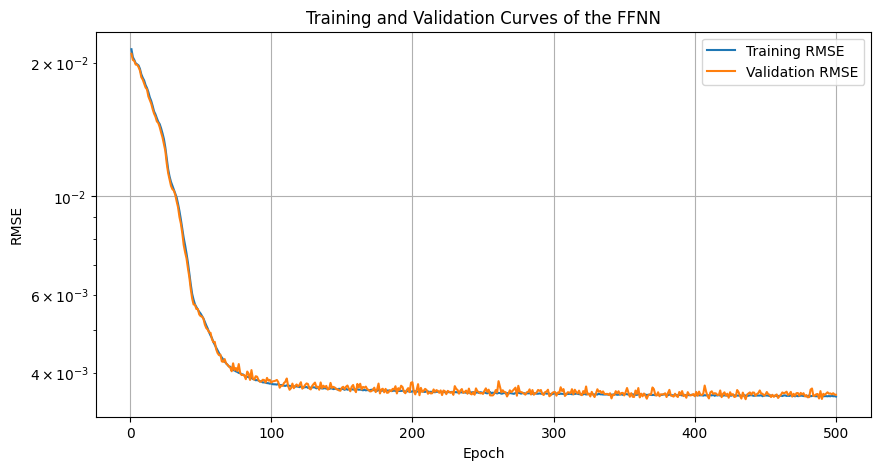

Training Progress: 100%|██████████| 500/500 [15:24<00:00,  1.85s/epoch, Training RMSE=0.0035, Validation RMSE=0.0036, LR=0.001000]

Training complete.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from google.colab import files

# Initialize and move model to device
layers = [3, 256, 512, 32]
ffnn_model = FeedForwardNet(layers)
ffnn_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ffnn_model.parameters(), lr=0.001)

# Initialize the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=80, verbose=True)

# Training loop
num_epochs = 500  # Adjust the number of epochs as needed
train_losses = []
val_losses = []

# Ensure any existing progress bar is closed
try:
    pbar.close()
except:
    pass

# Initialize the progress bar
pbar = tqdm(total=num_epochs, desc="Training Progress", unit="epoch")

for epoch in range(num_epochs):
    ffnn_model.train()
    train_loss = 0.0
    for inputs_batch, outputs_batch in train_loader:
        inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)

        # Forward pass
        outputs_pred = ffnn_model(inputs_batch)
        loss = torch.sqrt(criterion(outputs_pred, outputs_batch))
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation check
    ffnn_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_batch, outputs_batch in val_loader:
            inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)

            outputs_pred = ffnn_model(inputs_batch)
            loss = torch.sqrt(criterion(outputs_pred, outputs_batch))

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Update the scheduler with the validation loss (which it is monitoring)
    scheduler.step(val_loss)

    # Update the progress bar with RMSE for training and validation
    pbar.set_postfix({
        "Training RMSE": f"{train_loss:.4f}",
        "Validation RMSE": f"{val_loss:.4f}",
        "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
    })
    pbar.update(1)

    # Plot training curves every 50 epochs
    if (epoch + 1) % 50 == 0:
        clear_output(wait=True)  # Clear the output
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 2), train_losses, label='Training RMSE')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.title('Training and Validation Curves of the FFNN')
        plt.legend()
        plt.grid(True)
        plt.show()

pbar.close()
print('Training complete.')

# Save model
torch.save(ffnn_model.state_dict(), 'ffnn_model.pt')

# Download model
files.download('ffnn_model.pt')


## Recurrent Neural Network (with LSTMs or GRUs)

After performing grid search, the design of this model is described below:

*Input Size:*  1 (there are 3 timesteps, one for each DoA)

*Hidden State Size:* 256

*Number of hidden layers:* 2

*Linear Trasformation:*  256 -> 32

In [ ]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, recType):
        super(RNN, self).__init__()

        # Store the design-related hyperparameters
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.recType = recType

        # Depending on the type of RNN, create layers of GRU or LSTM units
        if self.recType=='GRU':
          self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        elif self.recType=='LSTM':
          self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Initialize the final linear transformation layer to "translate" the
        # hidden size of the RNN to the desired weight vector
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden states (h0), and cell states (c0) if LSTM is selected.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if self.recType =='LSTM':
          c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Depending on the RNN type, use the relative processing units
        if self.recType=='GRU':
          out,_ = self.gru(x,h0)
        elif self.recType=='LSTM':
          out,_ = self.lstm(x,(h0,c0))

        # Keep the output of the final timestep only
        out = out[:, -1, :]

        # Pass the RNN output through the linear layer transformation
        out = self.fc(out)

        return out

In [ ]:
# Example: Initialize a GRU model
gru_model = RNN(input_size=1,
                hidden_size = 256,
                num_layers = 2,
                output_size = 32,
                recType = 'GRU').to(device)

In [ ]:
# Create random input and send to device
# Input must have the shape: BATCH SIZE x SEQUENCE LENGTH x INPUT SIZE
input = torch.rand((1,3,1)).to(device)
# Get model output
out = gru_model(input)
print(out)

tensor([[-0.0340, -0.0089,  0.0303, -0.0444,  0.0226, -0.0143,  0.0074, -0.0502,
          0.0132, -0.0725,  0.0130,  0.0178, -0.0390, -0.0032,  0.0561,  0.0141,
         -0.0427, -0.0498, -0.0766, -0.0242,  0.0022,  0.0081, -0.0006, -0.0489,
         -0.0336, -0.0279, -0.0572,  0.0758, -0.0658, -0.0112,  0.0221, -0.0184]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


## Train the RNN-based models

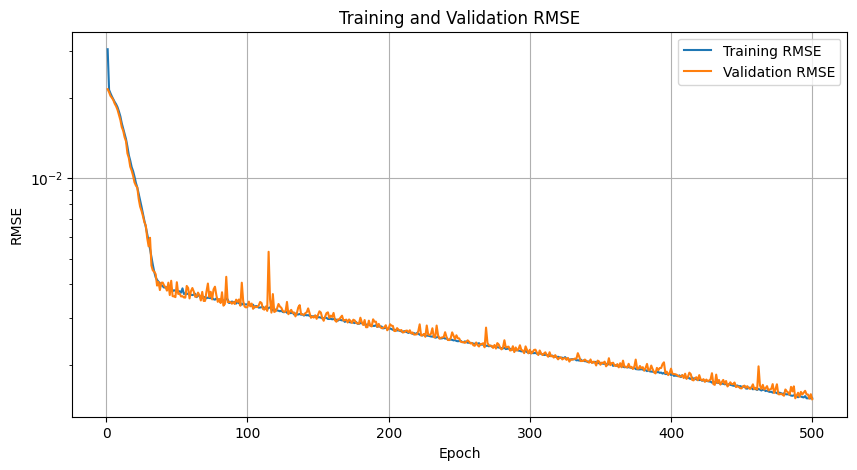

Training Progress: 100%|██████████| 500/500 [26:07<00:00,  3.14s/epoch, Training RMSE=0.0015, Validation RMSE=0.0015]

Training complete.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Define the RNN
input_size = 1  # Number of input features
hidden_size = 256  # Number of features in the hidden state
num_layers = 2  # Number of stacked RNN layers
output_size = 32  # Number of output features
recType = 'LSTM'  # Choose between 'GRU' and 'LSTM'
lstm_model = RNN(input_size, hidden_size, num_layers, output_size, recType)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Define scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, verbose=True)

# Training loop
num_epochs = 500  # Adjust the number of epochs as needed
train_losses = []
val_losses = []

# Ensure any existing progress bar is closed
try:
    pbar.close()
except:
    pass

# Initialize the progress bar
pbar = tqdm(total=num_epochs, desc="Training Progress", unit="epoch")

for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0.0
    for inputs_batch, outputs_batch in train_loader:
        # Make sure that input shape is BATCH SIZE x SEQUENCE LENGTH x INPUT SIZE
        inputs_batch = inputs_batch.reshape((inputs_batch.shape[0],inputs_batch.shape[1],input_size))
        # Move input-output to working device
        inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)
        # Forward pass
        outputs_pred = lstm_model(inputs_batch)
        loss = torch.sqrt(criterion(outputs_pred, outputs_batch))
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation check
    lstm_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs_batch, outputs_batch in val_loader:
            # Make sure that input shape is BATCH SIZE x SEQUENCE LENGTH x INPUT SIZE
            inputs_batch = inputs_batch.reshape((inputs_batch.shape[0],inputs_batch.shape[1],1))
            inputs_batch, outputs_batch = inputs_batch.to(device), outputs_batch.to(device)

            outputs_pred = lstm_model(inputs_batch)
            loss = torch.sqrt(criterion(outputs_pred, outputs_batch))

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    # Update the progress bar with RMSE for training and validation
    pbar.set_postfix({
        "Training RMSE": f"{train_loss:.4f}",
        "Validation RMSE": f"{val_loss:.4f}"
    })
    pbar.update(1)

    # Plot training curves every 50 epochs
    if (epoch + 1) % 50 == 0:
        clear_output(wait=True)  # Clear the output
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, epoch + 2), train_losses, label='Training RMSE')
        plt.plot(range(1, epoch + 2), val_losses, label='Validation RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.yscale('log')  # Set y-axis to logarithmic scale
        plt.title('Training and Validation RMSE')
        plt.legend()
        plt.grid(True)
        plt.show()

pbar.close()
print('Training complete.')

# Save model
torch.save(lstm_model.state_dict(), 'lstm_model.pt')

# Download model
files.download('lstm_model.pt')

## Test the accuracy of each model

### Define the necessary functions for comparison
(All functions were introduced in the previous lesson)

In [ ]:
def plot_radiation_pattern(weights, doas, num_points=360, title=None):
    """
    Plots the radiation pattern of a ULA based on provided weights.

    Parameters:
        weights (numpy array): Complex weights of the antenna elements.
        doas (list of floats): Angles of interest in degrees where lines should be drawn.
        num_points (int): Number of points to calculate in the plot (default is 360).
    """
    M = len(weights)  # Number of array elements
    d = 0.5  # Element spacing in wavelengths (assuming lambda = 1)
    theta = np.linspace(0, 2 * np.pi, num_points)  # Angles from 0 to 2*pi

    # Array factor calculation
    k = 2 * np.pi  # Assuming wavelength lambda = 1
    array_factor = np.zeros(num_points, dtype=complex)

    for m in range(M):
        array_factor += weights[m] * np.exp(1j * k * d * m * np.cos(theta))

    # Normalizing array factor
    array_factor = np.abs(array_factor) / np.max(np.abs(array_factor))

    # Convert to dB
    array_factor_db = 20 * np.log10(array_factor + 1e-10)  # Adding small value to avoid log(0)

    # Plotting
    plt.figure()
    plt.polar(theta, array_factor_db)
    if title==None:
      plt.title('Radiation Pattern')
    else:
      plt.title(title)

    # Add lines at specified angles (doas)
    for i, doa in enumerate(doas):
        doa_rad = np.deg2rad(doa)  # Convert degrees to radians
        color = 'blue' if i == 0 else 'red'
        plt.polar([doa_rad, doa_rad], [np.min(array_factor_db), np.max(array_factor_db)], color=color)
        plt.text(doa_rad, np.max(array_factor_db), f'{doa}°', color=color, fontsize=12,
                 horizontalalignment='center', verticalalignment='bottom')

    plt.show()

def produce_doas(M, mintheta, theta_start, theta_stop, maxcount, accuracydigits):
    count = 0 # Counts records
    doa_mat = np.zeros((maxcount, M)) # Empty array to store DoAs
    np.random.seed()  # Shuffle the seed for randomness
    while count < maxcount:
        minDth = 0
        while minDth < mintheta: # Minimum angular distance constraint

            # Create a DoA array of M incoming signals
            doas = theta_start + (theta_stop - theta_start) * np.random.rand(M)
            # Round every DoA
            doas = np.round(doas, accuracydigits)

            # Calculate the minimum distance in this array
            minDth = np.min(np.diff(np.sort(doas)))

        # Save the DoA array
        doa_mat[count, :] = doas
        count += 1 # Counter increase

    return doa_mat

def steering_vector(theta, N):
    # Simplified steering vector for angle theta considering a ULA of N elements,
    # isotropic point sources, and the distance between elements: lamda/2
    return np.exp(-1j * np.arange(N) * np.pi * np.cos(np.deg2rad(theta)))

def NSB(doas, N):
  M = len(doas)

  # Compute the steering matrix A
  A = np.array([steering_vector(doas[i], N) for i in range(M)]).T

  # Calculate Hermitian of A
  AH = A.conj().T

  # AH and A multiplication and diagonal loading
  AHA = np.matmul(AH, A) + 1e-6 * np.eye(M)

  # Unit vector
  u1 = np.zeros(len(doas)).T
  u1[0]= 1

  # Final steps
  wNSB = np.matmul(np.matmul(A,np.linalg.inv(AHA)),u1)

  return wNSB

## Test NN-based beamformers and NSB on a random DoA scenario

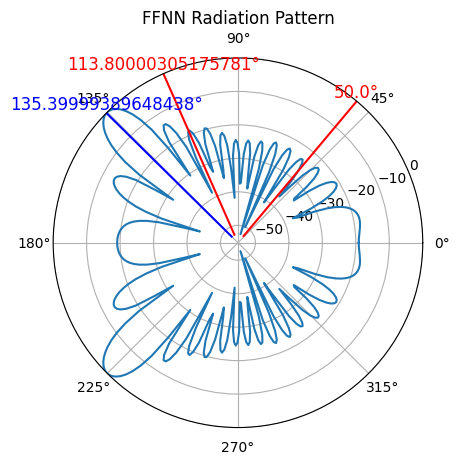

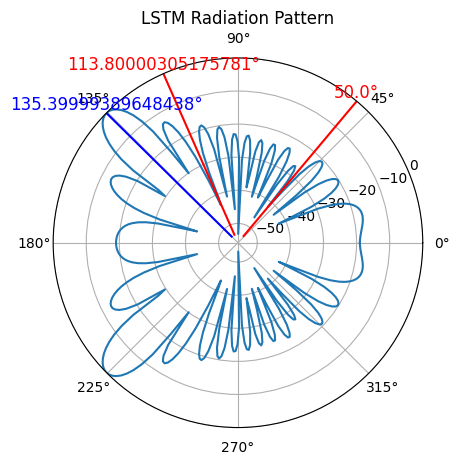

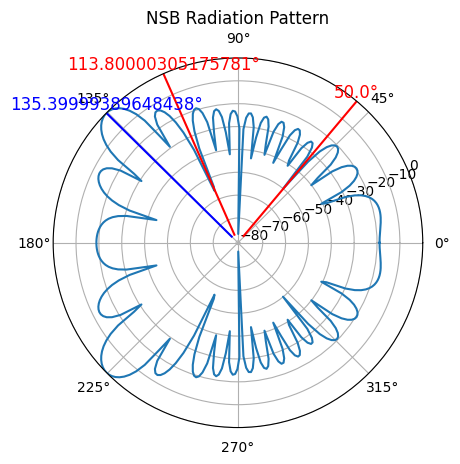

In [ ]:
# Random DoA scenario out of the Test Dataset:
doas_normalized = test_dataset[np.random.randint(0,len(test_dataset))][0].numpy()

# De-normalize
doas = doas_normalized * (theta_max - theta_min) + theta_min

# Round every DoA
doas = np.round(doas, 1)

# Produce NSB weights
wNSB = NSB(doas, N)

# Split into inputs and outputs
inputs = doas

# Convert to PyTorch tensors
inputs_tensor = torch.tensor(doas_normalized, dtype=torch.float32).to(device)

# Get models weight predictions
lstm_model.eval()
ffnn_model.eval()
out_ffnn = ffnn_model(inputs_tensor).flatten()
out_lstm = lstm_model(inputs_tensor.reshape((1,3,1))).flatten()

# De-normalize output
out_ffnn = (2*out_ffnn)-1
out_lstm = (2*out_lstm)-1

# Combine them into a complex array
out_ffnn = out_ffnn[:N] + 1j * out_ffnn[N:]
out_lstm = out_lstm[:N] + 1j * out_lstm[N:]

# Plot the radiation pattern and observe the DoAs of the list
plot_radiation_pattern(out_ffnn.cpu().detach().numpy(), doas, title = "FFNN Radiation Pattern")
plot_radiation_pattern(out_lstm.cpu().detach().numpy(), doas, title = "LSTM Radiation Pattern")

# Plot the radiation pattern and observe the DoAs of the list
plot_radiation_pattern(wNSB, doas, title ="NSB Radiation Pattern")

### !! REMINDER: PLEASE DOWNLOAD THE TRAINED MODELS FROM THE "FILES" SECTION !!

In [ ]:
from google.colab import files
files.download('ffnn_model.pt')
files.download('lstm_model.pt')